In [1]:
from wrangle import get_311_data, clean_311, split_separate_scale
from explore import get_chi_square, get_anova_test, make_dbad_relplot
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
import os
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [2]:
df_1= get_311_data()
df = clean_311(df_1)

In [3]:
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test, train_scaled, validate_scaled, test_scaled = split_separate_scale(df, stratify_by= None)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 428870 entries, 2497 to 495432
Data columns (total 30 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   case_id                   428870 non-null  int64         
 1   open_date                 428870 non-null  datetime64[ns]
 2   due_date                  428870 non-null  datetime64[ns]
 3   closed_date               428870 non-null  datetime64[ns]
 4   is_late                   428870 non-null  object        
 5   dept                      428870 non-null  object        
 6   call_reason               428870 non-null  object        
 7   case_type                 428870 non-null  object        
 8   case_status               428870 non-null  object        
 9   source_id                 428870 non-null  object        
 10  address                   428870 non-null  object        
 11  council_district          428870 non-null  int64         
 12 

In [5]:
df.council_district.isna().sum()

0

In [6]:
train.head()

,case_id,open_date,due_date,closed_date,is_late,dept,call_reason,case_type,case_status,source_id,address,council_district,longitude,latitude,days_open,resolution_days_due,days_before_or_after_due,level_of_delay,district_0,district_1,district_2,district_3,district_4,district_5,district_6,district_7,district_8,district_9,district_10,zipcode
413287,1016756563,2021-03-22,2021-03-25,2021-03-25,YES,Solid Waste Management,waste,No Pickup,Closed,Web Portal,"2430 LAKE LOUISE, SAN ANTONIO, 78228",7,2098452.0,13715006.0,3.0,3,0.0,On Time Response,0,0,0,0,0,0,0,1,0,0,0,78228
454053,1016816279,2021-04-19,2021-04-21,2021-04-19,NO,Trans & Cap Improvements,streets,Pavement Repair (Pothole),Closed,Web Portal,FAITH DR and LURA LN,7,2100261.0,13718518.0,0.0,2,2.0,Early Response,0,0,0,0,0,0,0,1,0,0,0,NaN
412793,1016755838,2021-03-22,2021-03-29,2021-03-31,YES,Solid Waste Management,waste,Carts(Removed from Service),Closed,Web Portal,"734 DONALDSON AVE, SAN ANTONIO, 78201",7,2115439.0,13716364.0,9.0,7,-2.0,On Time Response,0,0,0,0,0,0,0,1,0,0,0,78201
51664,1016211764,2020-05-26,2020-05-27,2020-05-26,NO,Unknown,traffic,Traffic Signals (Maintenance_Emergency),Closed,Web Portal,PEREIDA ST and S ST MARYS ST,1,2131315.0,13698007.0,0.0,1,1.0,Early Response,0,1,0,0,0,0,0,0,0,0,0,NaN
383234,1016708721,2021-02-26,2021-03-05,2021-03-01,NO,Solid Waste Management,waste,Carts(Damaged Cart),Closed,Web Portal,"6707 HARMONY FARM, SAN ANTONIO, 78249",8,2089165.0,13750628.0,3.0,7,4.0,Early Response,0,0,0,0,0,0,0,0,1,0,0,78249


## 5. Does category/department affect response time?

<Figure size 1440x720 with 0 Axes>

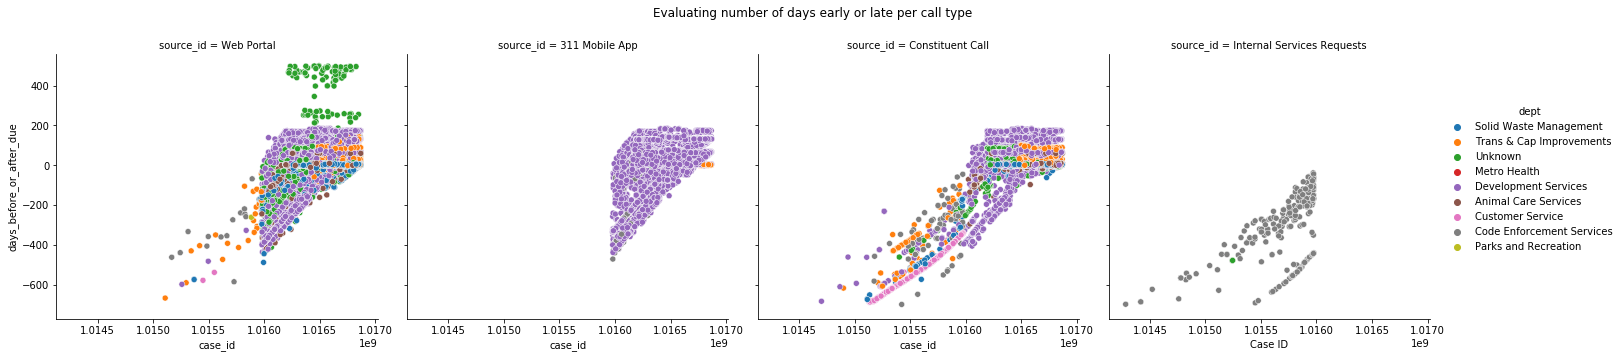

In [7]:
make_dbad_relplot(train)

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240167 entries, 413287 to 192063
Data columns (total 30 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   case_id                   240167 non-null  int64         
 1   open_date                 240167 non-null  datetime64[ns]
 2   due_date                  240167 non-null  datetime64[ns]
 3   closed_date               240167 non-null  datetime64[ns]
 4   is_late                   240167 non-null  object        
 5   dept                      240167 non-null  object        
 6   call_reason               240167 non-null  object        
 7   case_type                 240167 non-null  object        
 8   case_status               240167 non-null  object        
 9   source_id                 240167 non-null  object        
 10  address                   240167 non-null  object        
 11  council_district          240167 non-null  int64         
 1

#### Hypothesis Testing #1 (ANOVA)

$H_0$: There is no difference in mean days open between the departments.

$H_a$: There is a significant difference in days open in animal care services.

alpha ($\alpha$): 1 - confidence level (95% confidence level -> $\alpha = .05$)

In [9]:
import scipy.stats as stats
n = train.shape[0]     # number of observations
degf = n - 2        # degrees of freedom: the # of values in the final calculation of a statistic that are free to vary.
conf_interval = .95 # desired confidence interval
α = 1 - conf_interval
null_hypothesis = 'there is no difference in mean days open between the departments.'
F, p = stats.f_oneway( 
        train.days_open[train.dept== "Solid Waste Management"],
        train.days_open[train.dept== "Development Services"],
        train.days_open[train.dept== "Animal Care Services"],
        train.days_open[train.dept== "Unknown"],
        train.days_open[train.dept== "Trans & Cap Improvements"],
        train.days_open[train.dept== "Metro Health"],
        train.days_open[train.dept== "Code Enforcement Services"], 
        train.days_open[train.dept== "Customer Service"], 
        train.days_open[train.dept== "Parks and Recreation"]
        )
if p > α:
        print("We fail to reject the null hypothesis. The null hypothesis is that", null_hypothesis)
else:
        print("We reject the null hypothesis that", null_hypothesis)

We reject the null hypothesis that there is no difference in mean days open between the departments.


#### Is animal care services slower than the rest of the departments? If not, what is the slowest department?

In [10]:
train.columns

Index(['case_id', 'open_date', 'due_date', 'closed_date', 'is_late', 'dept',
       'call_reason', 'case_type', 'case_status', 'source_id', 'address',
       'council_district', 'longitude', 'latitude', 'days_open',
       'resolution_days_due', 'days_before_or_after_due', 'level_of_delay',
       'district_0', 'district_1', 'district_2', 'district_3', 'district_4',
       'district_5', 'district_6', 'district_7', 'district_8', 'district_9',
       'district_10', 'zipcode'],
      dtype='object')

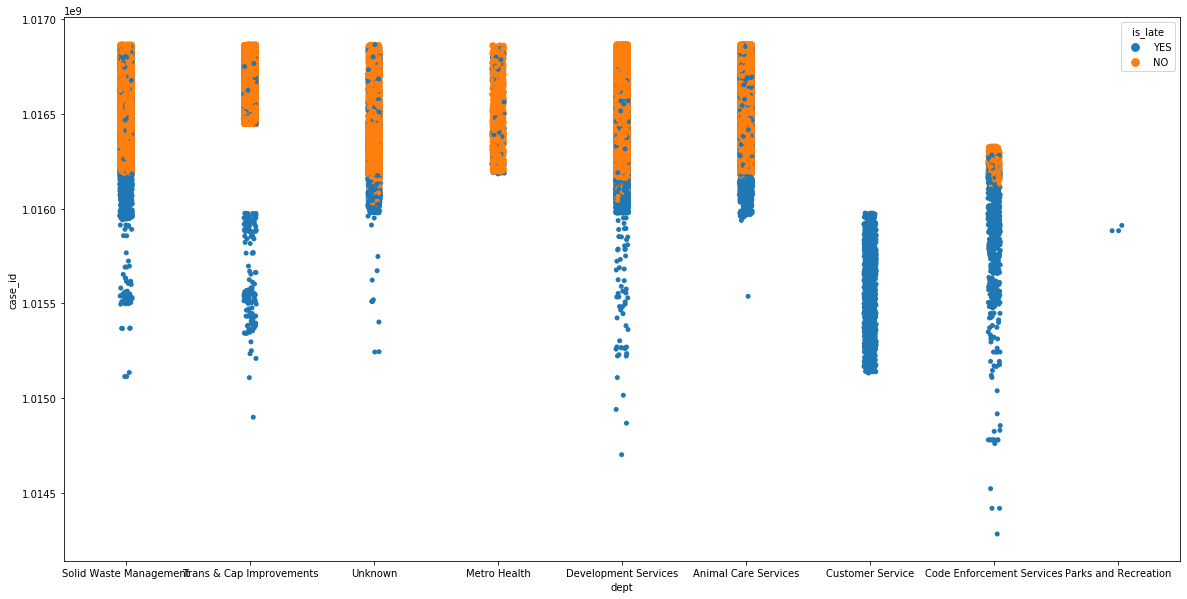

In [11]:
plt.figure(figsize=(20, 10))

sns.stripplot(x="dept", y="case_id", hue='is_late', data=train, jitter=0.05)

In [12]:
train.dept.value_counts()

Solid Waste Management       102365
Development Services          59864
Animal Care Services          38190
Unknown                       19560
Trans & Cap Improvements      16957
Metro Health                   1434
Code Enforcement Services       948
Customer Service                846
Parks and Recreation              3
Name: dept, dtype: int64

In [35]:
train_dept= train[train["dept"] == "Customer Service"]

In [37]:
train_dept.tail()

,case_id,open_date,due_date,closed_date,is_late,dept,call_reason,case_type,case_status,source_id,address,council_district,longitude,latitude,days_open,resolution_days_due,days_before_or_after_due,level_of_delay,district_0,district_1,district_2,district_3,district_4,district_5,district_6,district_7,district_8,district_9,district_10,zipcode
7152,1015773203,2019-08-23,2019-08-30,2020-11-23,YES,Customer Service,customer_service,Complaint,Closed,Constituent Call,"10111 ROSEANGEL LANE, San Antonio, 78023",7,2066319.0,13746130.0,458.0,7,-451.0,Very Late Response,0,0,0,0,0,0,0,1,0,0,0,78023
7760,1015844894,2019-09-28,2019-10-07,2020-11-23,YES,Customer Service,customer_service,Complaint,Closed,Constituent Call,"9519 ANDREW POINT, San Antonio, 78251",6,2072293.0,13723715.0,422.0,9,-413.0,Very Late Response,0,0,0,0,0,0,1,0,0,0,0,78251
4938,1015336803,2019-03-08,2019-03-15,2020-11-23,YES,Customer Service,customer_service,Complaint,Closed,Constituent Call,"1119 WOODLAWN W, San Antonio, 78201",1,2123535.0,13712633.0,626.0,7,-619.0,Extremely Late Response,0,1,0,0,0,0,0,0,0,0,0,78201
8419,1015904380,2019-10-31,2019-11-07,2020-11-24,YES,Customer Service,customer_service,Complaint,Closed,Constituent Call,"2830 LOMBRANO, San Antonio, 78228",5,2112037.0,13709759.0,390.0,7,-383.0,Very Late Response,0,0,0,0,0,1,0,0,0,0,0,78228
8205,1015887233,2019-10-21,2019-10-28,2020-11-24,YES,Customer Service,customer_service,Complaint,Closed,Constituent Call,BANDERA RD and BENRUS BLVD,7,2101468.0,13720612.0,400.0,7,-393.0,Very Late Response,0,0,0,0,0,0,0,1,0,0,0,NaN


## 6. Is response time for issue X different between geographical location Y when compared to the average response time? (or other geographical location?)

In [15]:
train.columns

Index(['case_id', 'open_date', 'due_date', 'closed_date', 'is_late', 'dept',
       'call_reason', 'case_type', 'case_status', 'source_id', 'address',
       'council_district', 'longitude', 'latitude', 'days_open',
       'resolution_days_due', 'days_before_or_after_due', 'level_of_delay',
       'district_0', 'district_1', 'district_2', 'district_3', 'district_4',
       'district_5', 'district_6', 'district_7', 'district_8', 'district_9',
       'district_10', 'zipcode'],
      dtype='object')

#### Hypothesis Testing #1 (ANOVA)

$H_0$: There is no difference in days before or after due date between the districts.

$H_a$: There is a significant difference in days before or after due date between the districts.

alpha ($\alpha$): 1 - confidence level (95% confidence level -> $\alpha = .05$)

In [16]:
get_anova_test(train)

We reject the null hypothesis that there is no difference in days before or after due date between the districts.


#### Hypothesis Testing #2 (Chi $^2$)

$H_0$: There is no difference in if a case resolution is late between the districts.

$H_a$: There is a difference if a case resolution is late date between the districts.

alpha ($\alpha$): 1 - confidence level (95% confidence level -> $\alpha = .05$)

In [17]:
get_chi_square(train)

We reject the null hypothesis that there is no difference in if a case resoution is late between the districts.


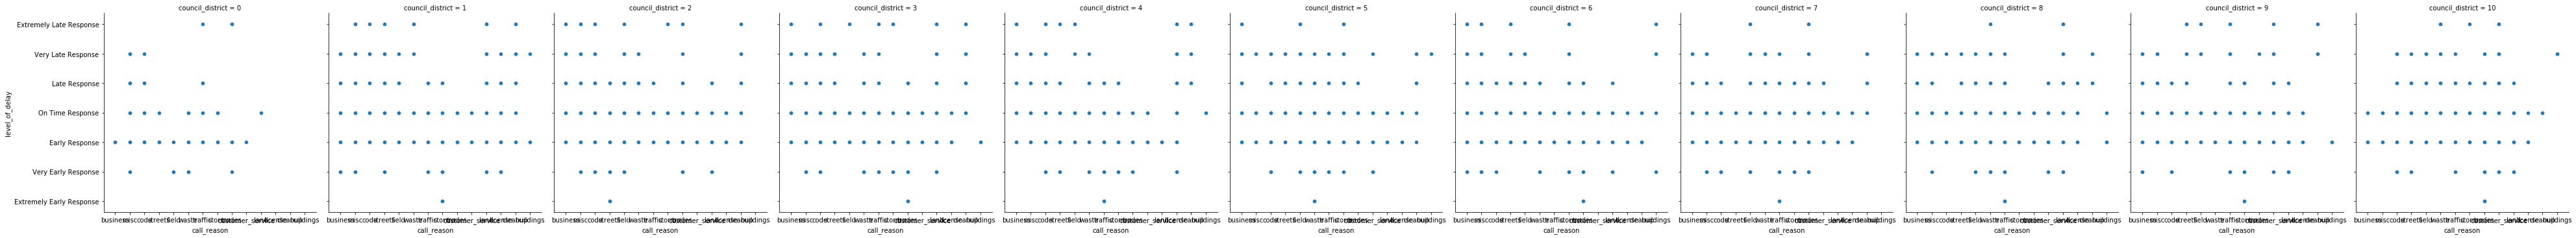

In [18]:
sns.relplot(x='call_reason', y='level_of_delay', col='council_district', data=train)

<Figure size 1440x720 with 0 Axes>

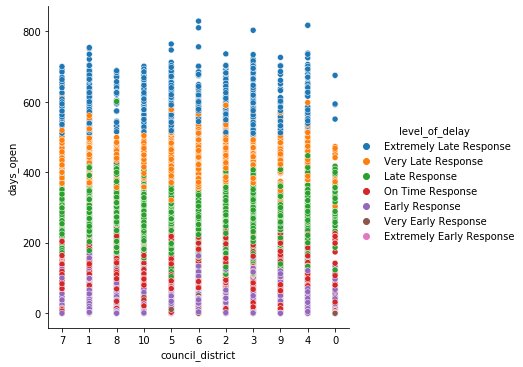

<Figure size 1440x720 with 0 Axes>

In [19]:
train['council_district'] = train['council_district'].astype('str') 
sns.relplot(data=train, x="council_district", y="days_open", hue="level_of_delay")
plt.figure(figsize=(20, 10))

Now that we know there is a general difference:
- is there is difference in level of delay for waste (most common reason for calls) between district 3 (largest southside district) and district 8/9 (wealthiest sa district)?

In [20]:
train.call_reason.value_counts()

waste               84243
code                60141
field               38228
misc                16971
traffic             13950
streets             13039
trades               5057
storm                3370
customer_service     2593
land                 1128
business              861
license               442
buildings             114
cleanup                30
Name: call_reason, dtype: int64

In [21]:
train['council_district'] = train['council_district'].astype('int') 

dist_3 = train[train["council_district"] == 3]
dist_8 = train[train["council_district"] == 8]
dist_9 = train[train["council_district"] == 9]

In [22]:
dist_3.days_open.mean()

21.70450914544684

In [23]:
dist_8.days_open.mean()

14.532278248067723

In [24]:
dist_9.days_open.mean()

13.290701151143669

In [25]:
train.call_reason.value_counts()

waste               84243
code                60141
field               38228
misc                16971
traffic             13950
streets             13039
trades               5057
storm                3370
customer_service     2593
land                 1128
business              861
license               442
buildings             114
cleanup                30
Name: call_reason, dtype: int64

In [26]:
dist_3_waste= dist_3[dist_3["call_reason"] == "waste"]
dist_8_waste= dist_8[dist_8["call_reason"] == "waste"]
dist_9_waste= dist_9[dist_9["call_reason"] == "waste"]

In [27]:
dist_3_waste.days_open.mean(), dist_8_waste.days_open.mean(), dist_9_waste.days_open.mean(),

(5.503168944345415, 5.179553423140801, 4.873774873774874)

In [28]:
dist_3_waste.head()

,case_id,open_date,due_date,closed_date,is_late,dept,call_reason,case_type,case_status,source_id,address,council_district,longitude,latitude,days_open,resolution_days_due,days_before_or_after_due,level_of_delay,district_0,district_1,district_2,district_3,district_4,district_5,district_6,district_7,district_8,district_9,district_10,zipcode
43947,1016204119,2020-05-21,2020-05-29,2020-05-25,NO,Solid Waste Management,waste,Carts(Cart Delivery),Closed,Web Portal,"315 STACE ST, SAN ANTONIO, 78204",3,2126730.0,13689658.0,4.0,8,4.0,Early Response,0,0,0,1,0,0,0,0,0,0,0,78204
182546,1016364978,2020-08-25,2020-08-31,2020-08-26,NO,Solid Waste Management,waste,No Pickup,Closed,Web Portal,"3909 MEADOWLARK AVE, SAN ANTONIO, 78210",3,2146216.0,13687594.0,1.0,6,5.0,Early Response,0,0,0,1,0,0,0,0,0,0,0,78210
231257,1016432937,2020-10-06,2020-10-09,2020-10-07,NO,Solid Waste Management,waste,No Pickup,Closed,Web Portal,"409 SAN JUAN RD, SAN ANTONIO, 78223",3,2152379.0,13666988.0,1.0,3,2.0,Early Response,0,0,0,1,0,0,0,0,0,0,0,78223
125878,1016292796,2020-07-14,2020-07-21,2020-07-15,NO,Solid Waste Management,waste,Carts(Lost-Stolen),Closed,Web Portal,"439 KOPPLOW, SAN ANTONIO, 78221",3,2129317.0,13671772.0,1.0,7,6.0,Early Response,0,0,0,1,0,0,0,0,0,0,0,78221
270308,1016503447,2020-11-09,2020-11-17,2020-11-10,NO,Solid Waste Management,waste,Carts(Removed from Service),Closed,Web Portal,"2501 HOLLYHILL, SAN ANTONIO, 78222",3,2162374.0,13692042.0,1.0,8,7.0,Early Response,0,0,0,1,0,0,0,0,0,0,0,78222


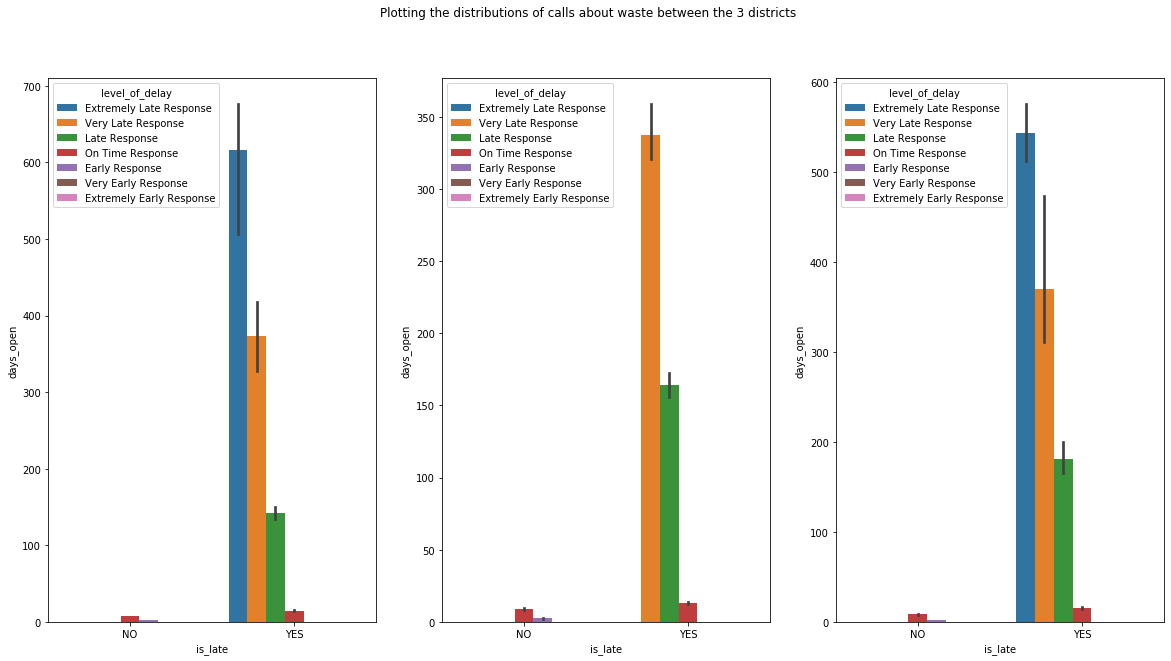

In [29]:
plt.figure(figsize=(20, 10))

plt.suptitle("Plotting the distributions of calls about waste between the 3 districts")

plt.subplot(1,3,1)
sns.barplot(
    data=dist_3_waste,
    x="is_late", y="days_open", hue="level_of_delay"
)
plt.title="District 3"
plt.subplot(1, 3, 2)
sns.barplot(
    data=dist_8_waste,
    x="is_late", y="days_open", hue="level_of_delay"
)
plt.title="District 8"

plt.subplot(1, 3, 3)
plt.title="District 9"
sns.barplot(
    data=dist_9_waste,
    x="is_late", y="days_open", hue="level_of_delay"
)


What about for code enforcement in the same 3 areas? (2nd most common reason for call)

In [30]:
dist_3_code= dist_3[dist_3["call_reason"] == "code"]
dist_8_code= dist_8[dist_8["call_reason"] == "code"]
dist_9_code= dist_9[dist_9["call_reason"] == "code"]

In [31]:
dist_3_code.days_open.mean(), dist_8_code.days_open.mean(), dist_9_code.days_open.mean(),

(58.831703819580234, 36.75458015267176, 38.73157370517928)

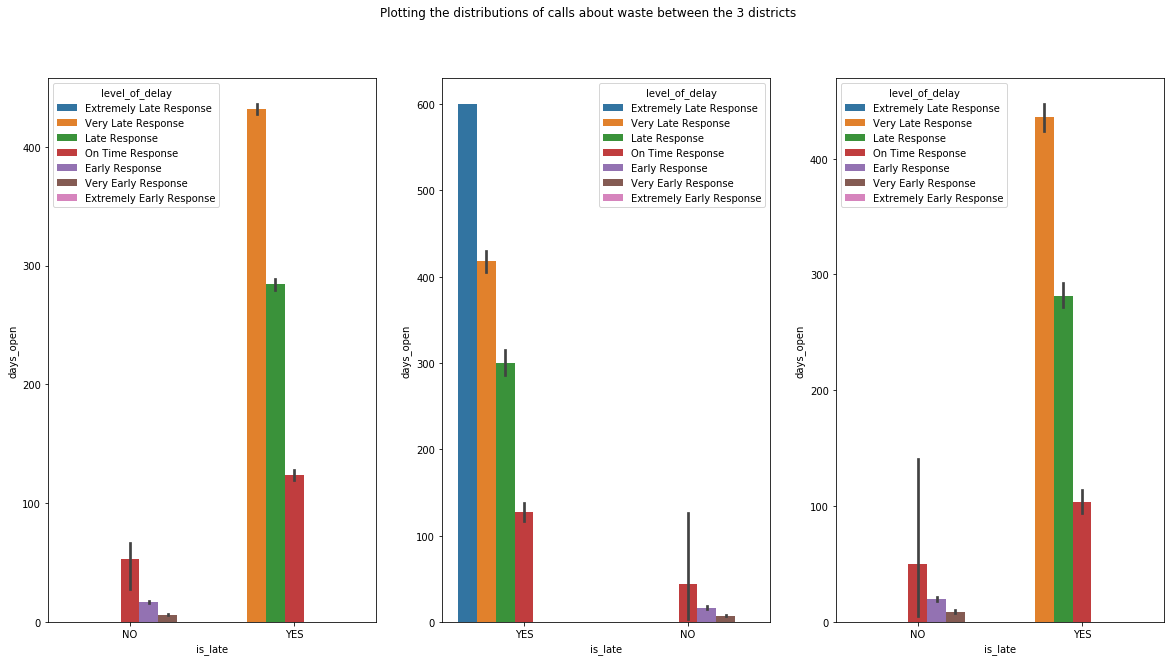

In [32]:
plt.figure(figsize=(20, 10))

plt.suptitle("Plotting the distributions of calls about waste between the 3 districts")

plt.subplot(1,3,1)
sns.barplot(
    data=dist_3_code,
    x="is_late", y="days_open", hue="level_of_delay"
)
plt.title="District 3"
plt.subplot(1, 3, 2)
sns.barplot(
    data=dist_8_code,
    x="is_late", y="days_open", hue="level_of_delay"
)
plt.title="District 8"

plt.subplot(1, 3, 3)
plt.title="District 9"
sns.barplot(
    data=dist_9_code,
    x="is_late", y="days_open", hue="level_of_delay"
)

Lastly I am going to explore if traffic/street calls response times vary between the 3 districts.

In [33]:
traffic             13950
streets             13039

SyntaxError: invalid syntax (<ipython-input-33-cc6ac67e6fd2>, line 1)

In [ ]:
dist_3_street= dist_3[dist_3["call_reason"] == "streets"]
dist_8_street= dist_8[ dist_8["call_reason"] == "streets"]
dist_9_street= dist_9[ dist_9["call_reason"] == "streets"]
dist_3_traffic= dist_3[dist_3["call_reason"] == "traffic"]
dist_8_traffic= dist_8[dist_8["call_reason"] == "traffic"]
dist_9_traffic= dist_9[dist_9["call_reason"] == "traffic"]

In [ ]:
dist_3_street.days_open.mean(), dist_8_street.days_open.mean(), dist_9_street.days_open.mean()

In [ ]:
dist_3_traffic.days_open.mean(), dist_8_traffic.days_open.mean(),dist_9_traffic.days_open.mean()

In [ ]:
plt.figure(figsize=(20, 10))

plt.suptitle("Plotting the distributions of calls about streets between the 3 districts")

plt.subplot(1,3,1)
sns.barplot(
    data=dist_3_street,
    x="is_late", y="days_open", hue="level_of_delay"
)
plt.title="District 3"
plt.subplot(1, 3, 2)
sns.barplot(
    data=dist_8_street,
    x="is_late", y="days_open", hue="level_of_delay"
)
plt.title="District 8"

plt.subplot(1, 3, 3)
plt.title="District 9"
sns.barplot(
    data=dist_9_street,
    x="is_late", y="days_open", hue="level_of_delay"
)

In [ ]:
plt.figure(figsize=(20, 10))

plt.suptitle("Plotting the distributions of calls about traffic between the 3 districts")

plt.subplot(1,3,1)
sns.barplot(
    data=dist_3_traffic,
    x="is_late", y="days_open", hue="level_of_delay"
)
plt.title="District 3"
plt.subplot(1, 3, 2)
sns.barplot(
    data=dist_8_traffic,
    x="is_late", y="days_open", hue="level_of_delay"
)
plt.title="District 8"

plt.subplot(1, 3, 3)
plt.title="District 9"
sns.barplot(
    data=dist_9_traffic,
    x="is_late", y="days_open", hue="level_of_delay"
)